# Model comparison

This Notebook's key objective is to compare different models applied on datasets produced with different data imputation strategies.

In [40]:
#importing libraries
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from itertools import product
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import scale


import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

# import custom dependencies
import ADNI_utilities as utils

## Reading and preparing the data

We have 5 datasets that we will use for modeling. Three of them use model-based imputation with different thresholds ($100\%$, $50\%$, and $30\%$) for missing values. Two use mean/mode based imputation at $30\%$ and $50\%$ thresholds.

In [47]:
#Initializing the data strucuture that will hold the test scores from different models
classifiers = {}
classifiers['LogisticRegression'] = 'Logistic'
classifiers['KNeighborsClassifier'] = 'kNN'
classifiers['DecisionTreeClassifier'] = 'Decision Tree'
classifiers['BaggingClassifier'] = 'Bagging'
classifiers['AdaBoostClassifier'] = 'Boosting'
classifiers['RandomForestClassifier'] = 'Random Forest'

filenames = {}
filenames['mean - 30pct'] = 'data_mean_upto_30pct_missing.csv'
filenames['mean - 50pct'] = 'data_mean_upto_50pct_missing.csv'
filenames['model - 30pct'] = 'data_modeled_upto_30pct_missing.csv'
filenames['model - 50pct'] = 'data_modeled_upto_50pct_missing.csv'
filenames['model - 100pct'] = 'data_modeled_upto_100pct_missing.csv'
            
result_container_multi = pd.DataFrame(index=list(filenames.keys()), columns=list(classifiers.values()))
result_container_binary = pd.DataFrame(index=list(filenames.keys()), columns=list(classifiers.values()))
estimators = {f_name:[] for f_name in list(filenames.values())}

In [3]:
#Setting up common parameters/config
import warnings
warnings.filterwarnings('ignore')

data_path = '../data/Imputed/'
resp_variable = 'DX_FINAL'
resp_vars = ['DXCOMB', 'DX_CHANGE', 'DX_FINAL', 'DX_BASE', 'DX_bl']
testsize = 0.2
rs = 42 # set random state so results are repeatable
run_binary = 1 #Set this variable to 1 if models with binary response variable are to be run

We will try a variety of models on the imputed data. We've decided to use KNN, DecisionTree, LogisticRegression, AdaBoost, Bagging, and Random Forest. The function below will perform a Grid CV search over all imputed datasets and accumulate the results of the best models.

In [4]:
def train_classifier_cv(estimator, param_grid, cv=5):
    """Trains the given estimator on each design matrix using grid search and
    cross validation. The best estimator and score are saved.
    
    # Arguments
        estimator: The estimator/classifier to train/score
        param_grid: the parameters to be used in the grid search
        cv: number of folds to be used for cross validation
    """
    for file_key in list(filenames.keys()):
        #Loading data
        file_nm = filenames[file_key]
        file_w_path = data_path + file_nm
        est_name = estimator.__repr__().split('(')[0]
        
        print(f'{est_name}: fitting {file_w_path}')

        df = pd.read_csv(file_w_path, index_col='RID')
        if 'modeled' in file_nm:
            df = utils.reverse_one_hot(resp_vars, df)
              
        df_train, df_test = train_test_split(df, test_size=testsize, shuffle=True, random_state=rs)

        y_train_multi = df_train[resp_variable]
        if (run_binary == 1 and not 'modeled' in file_nm):
            y_train_bin = df_train[resp_variable].apply(lambda x: 1 if x == 3 else 0)
              
        X_train = df_train.drop(resp_vars, axis=1).select_dtypes(['number'])

        y_test_multi = df_test[resp_variable]
        if (run_binary == 1 and not 'modeled' in file_nm):
            y_test_bin = df_test[resp_variable].apply(lambda x: 1 if x == 3 else 0)
              
        X_test = df_test.drop(resp_vars, axis=1).select_dtypes(['number'])

        #Running the model and storing results
        gs = GridSearchCV(estimator, param_grid=param_grid, cv=cv, n_jobs=-1,
                          return_train_score=True, iid=False)
        gs.fit(X_train, y_train_multi)
        score = gs.score(X_test, y_test_multi)
        result_container_multi.loc[file_key, classifiers[est_name]] = score
        estimators[file_nm].append((score, gs.best_estimator_))

        if (run_binary == 1 and not 'modeled' in file_nm):
            gs = GridSearchCV(estimator, param_grid=param_grid, cv=cv, n_jobs=-1,
                              return_train_score=True, iid=False)
            gs.fit(X_train, y_train_bin)
            result_container_binary.loc[file_key, classifiers[est_name]] = gs.score(X_test, y_test_bin)

In [91]:
# kNN
knn = KNeighborsClassifier(n_jobs=-1)
param_grid = {'n_neighbors': [2, 5, 10, 20, 50, 75, 100]}

train_classifier_cv(knn, param_grid)

KNeighborsClassifier: fitting ../data/Imputed/data_mean_upto_30pct_missing.csv
KNeighborsClassifier: fitting ../data/Imputed/data_mean_upto_50pct_missing.csv
KNeighborsClassifier: fitting ../data/Imputed/data_modeled_upto_30pct_missing.csv
KNeighborsClassifier: fitting ../data/Imputed/data_modeled_upto_50pct_missing.csv
KNeighborsClassifier: fitting ../data/Imputed/data_modeled_upto_100pct_missing.csv


In [92]:
# LogisticRegression
logr = LogisticRegression(multi_class="ovr", penalty='l2', max_iter=1000)
logr_params = {'C':10.0 ** np.arange(-4,4)}

train_classifier_cv(logr, logr_params)

LogisticRegression: fitting ../data/Imputed/data_mean_upto_30pct_missing.csv
LogisticRegression: fitting ../data/Imputed/data_mean_upto_50pct_missing.csv
LogisticRegression: fitting ../data/Imputed/data_modeled_upto_30pct_missing.csv
LogisticRegression: fitting ../data/Imputed/data_modeled_upto_50pct_missing.csv
LogisticRegression: fitting ../data/Imputed/data_modeled_upto_100pct_missing.csv


In [93]:
# Decision Tree
dt_clf = DecisionTreeClassifier()
dt_clf_params = {'max_depth':[2, 3, 5, 10, 20],
              'min_samples_leaf': [1, 2, 4, 6, 20]}

train_classifier_cv(dt_clf, dt_clf_params)

DecisionTreeClassifier: fitting ../data/Imputed/data_mean_upto_30pct_missing.csv
DecisionTreeClassifier: fitting ../data/Imputed/data_mean_upto_50pct_missing.csv
DecisionTreeClassifier: fitting ../data/Imputed/data_modeled_upto_30pct_missing.csv
DecisionTreeClassifier: fitting ../data/Imputed/data_modeled_upto_50pct_missing.csv
DecisionTreeClassifier: fitting ../data/Imputed/data_modeled_upto_100pct_missing.csv


In [94]:
# Bagging
dt_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier(dt_clf, n_jobs=-1, n_estimators=100)
bag_clf_params = {'base_estimator__max_depth':[2, 3, 5, 10, 20],
          'base_estimator__min_samples_leaf': [1, 2, 4, 6, 20]}

train_classifier_cv(bag_clf, bag_clf_params)

BaggingClassifier: fitting ../data/Imputed/data_mean_upto_30pct_missing.csv
BaggingClassifier: fitting ../data/Imputed/data_mean_upto_50pct_missing.csv
BaggingClassifier: fitting ../data/Imputed/data_modeled_upto_30pct_missing.csv
BaggingClassifier: fitting ../data/Imputed/data_modeled_upto_50pct_missing.csv
BaggingClassifier: fitting ../data/Imputed/data_modeled_upto_100pct_missing.csv


In [95]:
# Boosting
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(dt_clf, n_estimators=100, learning_rate=0.75)
ada_clf_params = {'base_estimator__max_depth':[2, 3, 5, 10, 20],
          'base_estimator__min_samples_leaf': [1, 2, 4, 6, 20]} 

train_classifier_cv(ada_clf, ada_clf_params)

AdaBoostClassifier: fitting ../data/Imputed/data_mean_upto_30pct_missing.csv
AdaBoostClassifier: fitting ../data/Imputed/data_mean_upto_50pct_missing.csv
AdaBoostClassifier: fitting ../data/Imputed/data_modeled_upto_30pct_missing.csv
AdaBoostClassifier: fitting ../data/Imputed/data_modeled_upto_50pct_missing.csv
AdaBoostClassifier: fitting ../data/Imputed/data_modeled_upto_100pct_missing.csv


In [96]:
# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_clf_params = {'max_depth':[2, 3, 5, 10, 20],
      'min_samples_leaf': [1, 2, 4, 6, 20]}  

train_classifier_cv(rf_clf, rf_clf_params)

RandomForestClassifier: fitting ../data/Imputed/data_mean_upto_30pct_missing.csv
RandomForestClassifier: fitting ../data/Imputed/data_mean_upto_50pct_missing.csv
RandomForestClassifier: fitting ../data/Imputed/data_modeled_upto_30pct_missing.csv
RandomForestClassifier: fitting ../data/Imputed/data_modeled_upto_50pct_missing.csv
RandomForestClassifier: fitting ../data/Imputed/data_modeled_upto_100pct_missing.csv


## Perfomance comparison

This section will present the performance differences across the models tested by our group.

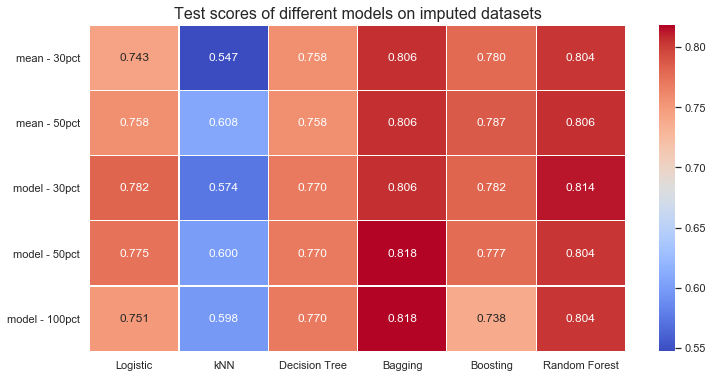

In [97]:
#Plotting the results as a heat map
fig, ax = plt.subplots(1,1, figsize=(12,6))

ax = sns.heatmap(result_container_multi.astype('float64'), annot=True, linewidths=0.1, fmt='.3f', cmap='coolwarm')
ax.set_title('Test scores of different models on imputed datasets', fontsize=16);
plt.show()

The heatmap above represents a brief summary of our findings. It shows test scores for the tested models on datasets built with different imputation strategies. The first finding is that kNN and Logistic Classification are consistently outperformed by any strategy using Decision Trees - both the simple trees and the ensemble methods using trees.

Among the methods using decision trees, Bagging shows the greatest performance - achieving more than 80% accuracy regardless of the imputation strategy. Especially for Bagging, modeling seems like a better imputation strategy than using the mean of the initial values found on the data. Although this conclusion is not true with all models, it seems generally that on our problem, model-based imputation slightly improves model performance vs using the mean/mode imputation.

We will now save the model results to disk for further analysis.

In [6]:
from joblib import dump, load

# Save the feature importance information from the ensemble classifiers
model_path = '../data/Models/Feature_Importance/'
for key in list(estimators.keys()):
    features = utils.get_feature_names(data_path, key, resp_vars)
    key_sub = key.split('data_')[1].split('pct')[0]
    for score, model in estimators[key]:
        model_nm = model.__repr__().split('(')[0]
        dump(model, f'../data/Models/{model_nm}_{key_sub}.joblib') 
        
        # Check to see if estimators_ attribute exists (ensemble classifiers)
        if getattr(model, 'estimators_', None) is not None:
            df = pd.DataFrame(columns=features)
            for estimator in model.estimators_:
                df = df.append(pd.Series(estimator.feature_importances_, index=df.columns),
                               ignore_index=True)
            df.to_csv(model_path + f'{model_nm}_{key_sub}.csv')
            
        # Check to see if coef_ attribute exists
        elif getattr(model, 'coef_', None) is not None:
            df = pd.DataFrame(data=model.coef_, columns=features, index=model.classes_)
            #df = df.append(pd.Series(model.coef_, index=df.columns), ignore_index=True)
            df.to_csv(model_path + f'{model_nm}_{key_sub}.csv')
            

Next we will explore the decision boundaries of each model.

## Dimensionality reduction

We have also explored the possibility of using PCA to reduce the dimensionality of our dataset and reach additional conclusions regarding our dataset and regarding AD diagnosis prediction.

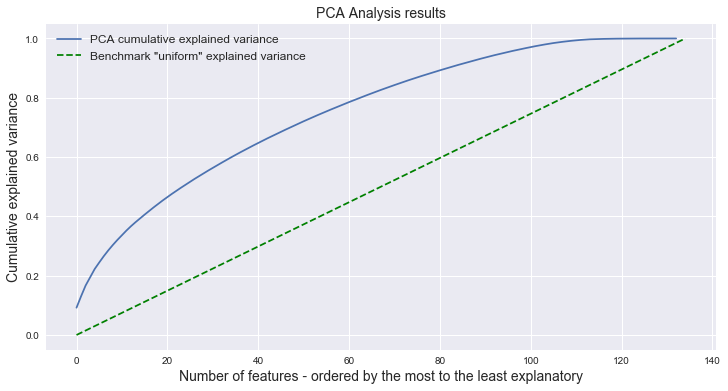

In [64]:
#PCA

#Reading the "strictest" dataset to apply PCA techniques
df = pd.read_csv(data_path + 'data_mean_upto_30pct_missing.csv')

df_train, df_test = train_test_split(df, test_size=testsize, shuffle=True, random_state=rs)
y_train_multi = df_train[resp_variable]
X_train = df_train.drop(resp_vars, axis=1).select_dtypes(['number'])
X_train = scale(X_train)

#y_test_multi = df_test[resp_variable]
#X_test = df_test.drop(resp_vars, axis=1).select_dtypes(['number'])
#X_test = scale(X_test)

#Running the PCA routine
pca = PCA()
pca.fit(X_train)

#Plotting the results
fig, ax = plt.subplots(1,1, figsize=(12,6))

plt.plot(np.cumsum(pca.explained_variance_ratio_), label='PCA cumulative explained variance')
plt.plot(np.linspace(0,1,135), 'g--', label='Benchmark "uniform" explained variance')
plt.legend(fontsize=12)
ax.set_xlabel('Number of features - ordered by the most to the least explanatory', fontsize=14)
ax.set_ylabel('Cumulative explained variance', fontsize=14)
ax.set_title('PCA Analysis results', fontsize=14);

As one can see in the plot above, there is not a strong explanatory power concentration on any principal component. Out of 133 components on the select dataset, more than 80 are needed to achieve 90% variance explanation. The top 20 components explain less than 50% of the variance. It is interesting to notice that, after the 20th and before the 100th component, the blue line is almost "parallel" to the green benchmark line - showing that there is very limited explanatory power concentration.

For this reason, added to the fact that similar results hold for all imputation strategies, we have decided not to use PCA as a tool to further improve our models.

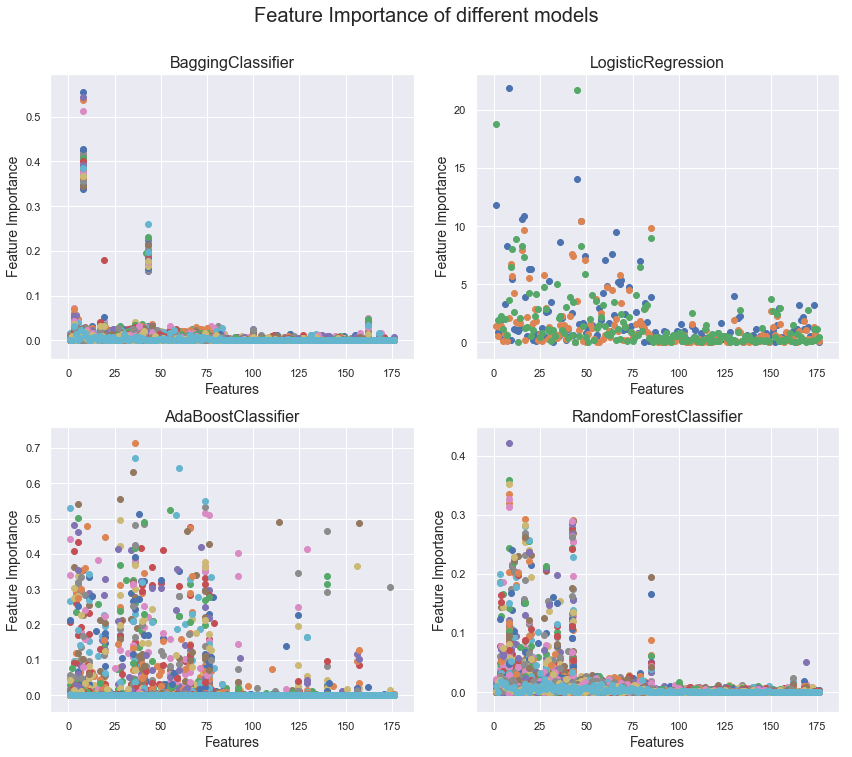

In [118]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

from glob import glob
feature_import = glob('../data/Models/Feature_Importance/*_modeled_upto_50.csv')
    
for fi, ax in zip(feature_import, axes.ravel()):
    df = pd.read_csv(fi, index_col=0)
    x = np.arange(1, df.shape[1]+1)
    
    title = fi.split('/')[-1].split('_')[0]
    ax.set_xlabel('Features', size=14)
    ax.set_ylabel('Feature Importance', size=14)
    ax.set_title(title, size=16)
    
    for i in df.index:
        ax.scatter(x, np.abs(df.loc[i]))
        
fig.tight_layout()
fig.suptitle("Feature Importance of different models", size=20, y=1.05)
plt.show()

In [ ]:
df.reindex_axis(df.mean().sort_values().index, axis=1)
fig, axes = plt.subplots(1, 1, figsize=(8,8))

from glob import glob
feature_import = glob('../data/Models/Feature_Importance/*_modeled_upto_50.csv')
    
for fi, ax in zip(feature_import, axes.ravel()):
    df = pd.read_csv(fi, index_col=0)
    x = np.arange(1, df.shape[1]+1)
    
    ax.set_xlabel('Features', size=14)
    ax.set_ylabel('Feature Importance', size=14)
    ax.set_title(fi.split('/')[-1].split('_')[0], size=16)
    
    for i in df.index:
        ax.scatter(x, df.loc[i])
fig.tight_layout()
fig.suptitle("Feature Importance of different models", size=20, y=1.05)
plt.show()


In [11]:
df = pd.read_csv('../data/Imputed/data_mean_upto_30pct_missing.csv')

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=rs)
resp_vars = ['DXCOMB', 'DX_CHANGE', 'DX_FINAL', 'DX_BASE', 'DX_bl']

y_train_multi = df_train['DX_FINAL']
y_train_bin = df_train['DX_FINAL'].apply(lambda x: 1 if x == 3 else 0)
X_train = df_train.drop(resp_vars, axis=1).select_dtypes(['number'])

y_test_multi = df_test['DX_FINAL']
y_test_bin = df_test['DX_FINAL'].apply(lambda x: 1 if x == 3 else 0)
X_test = df_test.drop(resp_vars, axis=1).select_dtypes(['number'])